#### Experimental setup

In [2]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Local Binary Pattern (LBP)

#### Preparing images

In [3]:
file_path = 'images/'

image_files = []
for f in os.listdir(file_path):
    if f.endswith(('.png')): 
        image_files.append(f)

# Read the images
images = []
for file in image_files:
    image_path = os.path.join(file_path, file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    images.append(image)

# Resize the images
images = [cv2.resize(image, (256, 256)) for image in images]

# Normalize the pixel values
images = [image / 255.0 for image in images]

#### Defining the LBP operator

In [4]:
def lbp_operator(image):
    rows, cols = image.shape
    lbp_image = np.zeros((rows, cols), dtype=np.uint8)
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            center = image[i, j]
            neighbors = [image[i - 1, j - 1], image[i - 1, j], image[i - 1, j + 1],
                          image[i, j - 1], image[i, j + 1],
                          image[i + 1, j - 1], image[i + 1, j], image[i + 1, j + 1]]
            binary_code = ''
            for neighbor in neighbors:
                if neighbor > center:
                    binary_code += '1'
                else:
                    binary_code += '0'
            lbp_image[i, j] = int(binary_code, 2)
    return lbp_image

# Apply the LBP operator to each image
lbp_images = []
for image in images:
    lbp_images.append(lbp_operator(image))

# Extract histograms from the LBP images
histograms = []
for lbp_image in lbp_images:
    hist = cv2.calcHist([lbp_image], [0], None, [256], [0, 256])
    histograms.append(hist)

#### Pandas DataFrame to store the histogram values

In [5]:
df = pd.DataFrame()

# Split the histogram values into 5 columns
for i, histogram in enumerate(histograms):
    col1 = histogram[:51].flatten()
    col2 = histogram[51:102].flatten()
    col3 = histogram[102:153].flatten()
    col4 = histogram[153:204].flatten()
    col5 = histogram[204:255].flatten()
    df[f'Image {i+1}_Col1'] = col1
    df[f'Image {i+1}_Col2'] = col2
    df[f'Image {i+1}_Col3'] = col3
    df[f'Image {i+1}_Col4'] = col4
    df[f'Image {i+1}_Col5'] = col5
    
df.head()

,Image 1_Col1,Image 1_Col2,Image 1_Col3,Image 1_Col4,Image 1_Col5,Image 2_Col1,Image 2_Col2,Image 2_Col3,Image 2_Col4,Image 2_Col5,...,Image 4_Col1,Image 4_Col2,Image 4_Col3,Image 4_Col4,Image 4_Col5,Image 5_Col1,Image 5_Col2,Image 5_Col3,Image 5_Col4,Image 5_Col5
0,38894.0,9.0,8.0,15.0,10.0,35597.0,6.0,11.0,13.0,7.0,...,27087.0,15.0,42.0,40.0,22.0,36841.0,7.0,14.0,15.0,15.0
1,406.0,24.0,17.0,10.0,10.0,497.0,10.0,28.0,4.0,10.0,...,609.0,46.0,57.0,14.0,26.0,405.0,23.0,33.0,11.0,7.0
2,343.0,9.0,279.0,14.0,11.0,445.0,14.0,382.0,22.0,7.0,...,766.0,8.0,604.0,44.0,12.0,327.0,6.0,357.0,15.0,7.0
3,268.0,20.0,1270.0,29.0,31.0,381.0,28.0,1084.0,19.0,30.0,...,384.0,50.0,1135.0,44.0,49.0,302.0,33.0,766.0,29.0,31.0
4,614.0,39.0,28.0,40.0,355.0,531.0,44.0,35.0,23.0,376.0,...,561.0,70.0,80.0,55.0,363.0,444.0,28.0,15.0,39.0,575.0


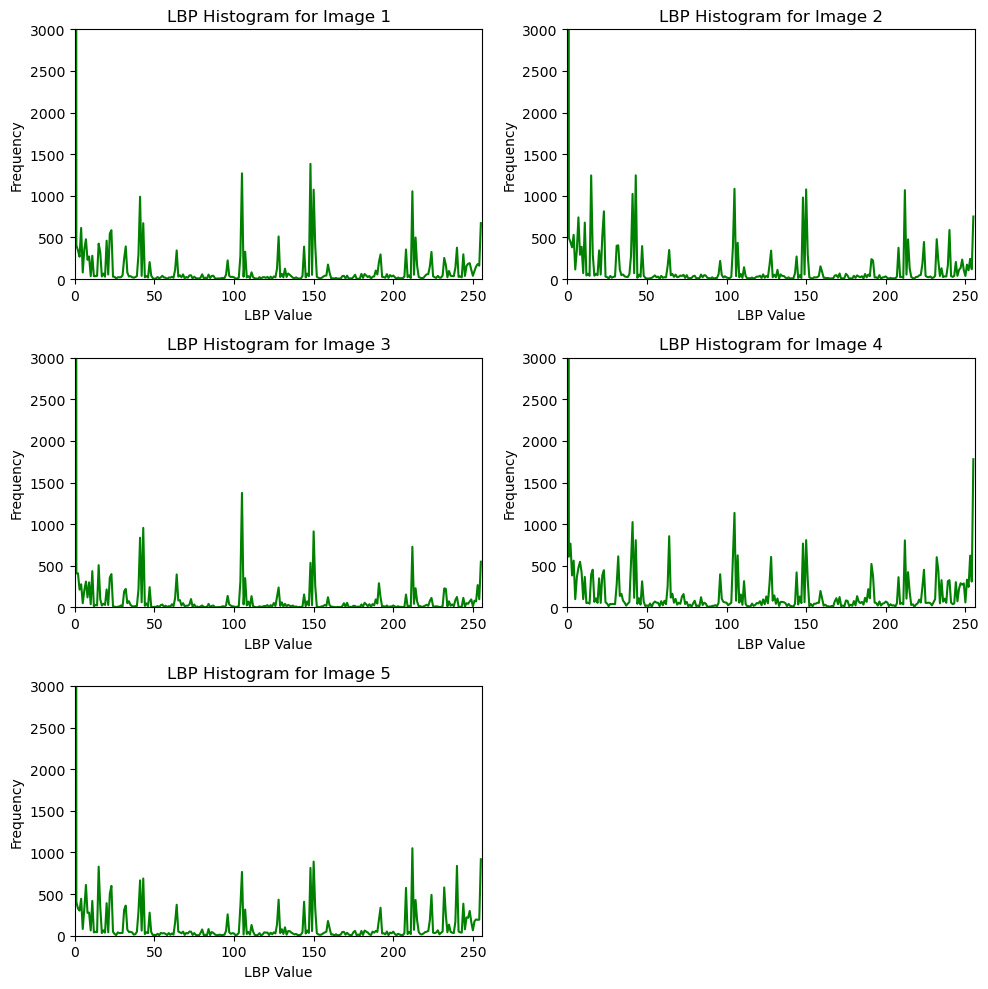

In [6]:
n_images = len(lbp_images)
fig, axs = plt.subplots(3, 2, figsize=(10, 10)) 
axs = axs.flatten()

for i, (lbp_image, histogram) in enumerate(zip(lbp_images, histograms)):
    if i < 5:  # plot 5 images
        axs[i].plot(histogram, color='green')
        axs[i].set_title(f'LBP Histogram for Image {i+1}')
        axs[i].set_xlabel('LBP Value')
        axs[i].set_ylabel('Frequency')
        axs[i].set_xlim([0, 256])
        axs[i].set_ylim([0, 3000])

# Remove any unused subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## Deep Learning-Based Feature Extraction - CNNs 
Even without full training, here I've used a pre-trained models like VGG16 for feature extraction. This model can capture complex features and patterns, including those indicative of fractures.

#### File path and image dimensions

In [7]:
file_path = 'images/'
img_height, img_width = 224, 224  

image_files = []
for f in os.listdir(file_path):
    if f.endswith(('.png')): 
        image_files.append(f)

#### Preprocessing the images

In [8]:
# Initialize list for images and labels
images = []
labels = []

# Load and preprocess the images
for file in image_files:
    # Extract class label from file path (if necessary)
    label = file.split('_')[0]  # Adjust based on your directory structure
    labels.append(label)
    
    # Load and preprocess the image
    image_path = os.path.join(file_path, file)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read the image in color
    image = cv2.resize(image, (img_height, img_width))  # Resize the image
    image = image / 255.0  # Normalize pixel values
    images.append(image)

# Convert list of images to a numpy array
images = np.array(images)

#### Loading pre-trained CNN model (VGG16)

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Create a model that outputs features from the last convolutional block
model = Model(inputs=base_model.input, outputs=base_model.output)

In [10]:
# Extract features
features = model.predict(images)

# Reshape features to a 2D array (flatten the 3D feature maps)
features = features.reshape(features.shape[0], -1)

# Convert the features to a DataFrame
df = pd.DataFrame(features)

# Optionally, add labels to the DataFrame
df['label'] = labels

# Show the first few rows of the DataFrame
df.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step


,0,1,2,3,4,5,6,7,8,9,...,25079,25080,25081,25082,25083,25084,25085,25086,25087,label
0,0.208599,0.0,0.0,0.000000,0.214550,0.0,0.0,0.0,0.0,0.0,...,0.016094,0.772915,0.0,0.0,1.037321,0.000000,0.0,1.127378,0.0,p
1,0.103860,0.0,0.0,0.000000,0.161417,0.0,0.0,0.0,0.0,0.0,...,0.073140,0.396369,0.0,0.0,0.709022,0.033648,0.0,0.712149,0.0,p
2,0.059549,0.0,0.0,0.019098,0.309822,0.0,0.0,0.0,0.0,0.0,...,0.657487,0.808756,0.0,0.0,0.290817,0.000000,0.0,0.545464,0.0,p
3,0.607354,0.0,0.0,0.000000,0.119035,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.451734,0.0,0.0,0.308710,0.000000,0.0,0.865862,0.0,p
4,0.035797,0.0,0.0,0.038542,0.209219,0.0,0.0,0.0,0.0,0.0,...,0.011185,0.000000,0.0,0.0,0.232910,0.000000,0.0,1.098902,0.0,p


## Principal Component Analysis (PCA)
PCA reduces the dimensionality of the data while preserving most of the variance, which can highlight the most significant features in the images. This method is particularly useful when dealing with large datasets.

#### File path and image dimensions

In [19]:
file_path = 'images/'
img_height, img_width = 224, 224

### Getting images from the directory

In [20]:
image_files = []
for f in os.listdir(file_path):
    if f.endswith(('.png')): 
        image_files.append(f)

#### Loading and preprocessing the images

In [21]:
# Initialize lists for images and labels
images = []
labels = []

for file in image_files:
    # Extract class label from file path
    label = file.split('_')[0] 
    labels.append(label)
    
    image_path = os.path.join(file_path, file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale
    image = cv2.resize(image, (img_height, img_width))  # Resize the image
    image = image / 255.0  # Normalize pixel values
    images.append(image)

#### Convert list of images to a numpy array and flatten each image to 1D

In [22]:
images = np.array(images)
n_samples, h, w = images.shape
images_flattened = images.reshape(n_samples, h * w)

#### Standardization the data before applying PCA

In [23]:
scaler = StandardScaler()
images_flattened = scaler.fit_transform(images_flattened)

#### Applying PCA

In [24]:
n_components = min(n_samples, images_flattened.shape[1])
pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(images_flattened)

#### Converting the PCA-transformed features to a DataFrame

In [25]:
df = pd.DataFrame(pca_features)
# labels to the DataFrame
df['label'] = labels
df

,0,1,2,3,4,label
0,-2.980080,-69.829314,-61.485641,116.536532,1.102243e-12,p
1,-122.912886,-6.014315,147.646928,5.494925,1.102243e-12,p
2,-56.408338,171.869815,-69.712213,-12.854319,1.102243e-12,p
3,223.266224,18.218336,50.555330,-15.799947,1.102243e-12,p
4,-40.964920,-114.244522,-67.004404,-93.377190,1.102243e-12,p
